<h1 style="font-size:30px;">Non-Maximum Suppression (NMS)</h1>

In many cases, detection algorithms do not output a single detection per ground-truth object. What they do is create a cloud of detections that cover the whole object or parts of it. Such situations call for a mechanism that eliminates the less desirable detections while preserving only the most accurate detection for each object. The algorithm that achieves this goal is called **Non-Maximum Suppression (NMS)**.

<img src="https://www.learnopencv.com/wp-content/uploads/2020/10/c4-w8-nms.jpg" width=700>

<center>Reference: <a href="https://arxiv.org/pdf/1704.04503.pdf">Improving Object Detection With One Line of Code</a></center>

## Table of Contents
* [1 Introduction to Non-Maximum Supression (NMS)](#1-Introduction-to-Non\-Maximum-Supression-(NMS))
* [2 NMS and Soft-NMS Implementation](#2-NMS-and-Soft\-NMS-Implementation)
* [3 Check the Implementation](#3-Check-the-Implementation)

In [1]:
%matplotlib inline
import os
import requests
import zipfile

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from PIL import Image

plt.rcParams["figure.figsize"] = (10, 10)

2022-05-01 22:11:10.743547: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-01 22:11:10.743581: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 1 Introduction to Non-Maximum Suppression (NMS)

Object detection models produce detections in the form of bounding boxes that have corresponding confidence scores. It is common that each object in an image will generate many bounding box detections with various sizes and locations relative to the detected object. Each of the bounding box detections will have an associated confidence score, and ideally, the detection with the highest score represents the most accurate detection (compared to ground truth).

The NMS algorithm attempts to eliminate all but the most accurate bounding box. NMS start with the most confident detection, suppressing all other detections that highly overlap with it. It repeats the process for the second most confident detection next, and so on; again and again suppressing those detections that are less confident. Thus it manages to filter out all less relevant detections.

### 1.1 NMS Algorithm

The algorithm inputs a list of the detected `dbox_list` boxes with their scores (`dbox_scores_list`).
We also need to select a suppression threshold (`threshold`).


We have already covered the Intersection over Union (IoU) metric in an earlier notebook. For the two boxes, it measures the ratio of the area of their intersection to the area of their union. Here we will use IoU to select the boxes to suppress.

The following steps represent the algorithm for **NMS**:
1. Sort the detected boxes by their confidence score.
2. Select the detected box having the current maximum score (`max_score_dbox`).
3. Remove this box from the `dbox_list`.
4. Suppress other detected boxes that highly overlap this box. By high
overlap, we mean that the IoU value is higher than the
suppression threshold value.
5. Repeat steps 2-5 for other boxes left in `dbox_list`.


### 1.2 Failure Modes in NMS
**Before we jump to the formal NMS algorithm and its implementation, let's walk through an example as depicted in the image below:**

<img src="https://opencv.org/wp-content/uploads/2022/05/c4-06-nms-horses-example.png" width="600">

<center>Reference: <a href="https://arxiv.org/pdf/1704.04503.pdf">Improving Object Detection With One Line of Code</a></center>

Non-maximum suppression starts with a list of detection boxes $\mathcal{B}$ with scores $\mathcal{S}$. There are two detections (for two horses) in the image above:
- The red detection has a confidence score of `0.95`
- The green detection has a confidence score of `0.80`

After selecting the detection with the maximum score $\mathcal{M}$, it removes it from the set $B$ and appends it to the set of final detections $\mathcal{D}$. It also removes any box which has an overlap greater than a threshold $N_t$ with $\mathcal{M}$ in the set $\mathcal{B}$. This process is repeated for remaining boxes $\mathcal{B}$. A major issue with non-maximum suppression is that it sets the score for neighboring detections to zero. Thus, if an object was actually present in that overlap threshold (the horse with the green detection), it would be missed and this would lead to a drop in average precision. However, if we lower the detection scores as a function of its overlap with $\mathcal{M}$, it would still be in the ranked list, although with a lower confidence. Assigning a lower score on the basis of overlap is called **Soft-NMS**. 

In the image above, the green bounding box has a confidence score of `0.80`. Instead of suppressing this score to 0, it would be better if we could adjust the score to a lower value like `0.4` based on the amount of overlap between the two bounding boxes.

Here, we will be looking at both the algorithms and their implementations. Also, we will show you through an example why the NMS algorithm is so important; and what **generally** makes the **Soft-NMS** better than **NMS**.

### 1.3 From NMS to Soft-NMS

NMS is a pretty straightforward algorithm that has been improved upon. In this section, we will describe a key enhancement to the base algorithm called **Soft-NMS** as detailed in the original research paper [Improving Object Detection With One Line of Code](https://arxiv.org/pdf/1704.04503.pdf).


Both algorithms are depicted in the figure below from the paper referenced above.

<img src="https://opencv.org/wp-content/uploads/2022/05/c4-06-nms-algorithm.png" width="500">

<center>Reference: <a href="https://arxiv.org/pdf/1704.04503.pdf">Improving Object Detection With One Line of Code</a></center>

You can see the original NMS steps in the red box, while the green box represents Soft NMS. Now, let's focus on the score recalculation. In NMS, it can be written as:

$$
s_i = \left\{
\begin{array}{ll}
0{, } & iou(\mathcal{M},b_i) \geqslant N_t\textrm{,}\\
s_i{, } & iou(\mathcal{M},b_i) < N_t\textrm{.}\\
\end{array} \right.
$$

It turns out that the box exclusion rule is quite hard: if IoU is greater than the predefined threshold value, the box will be removed, and its confidence score will be set to zero. However, it can be softened by just decreasing the score of the box with high $\mathcal{M}$ (detected box with a maximum score) overlap:


$$
s_i = \left\{
\begin{array}{ll}
s_i(1 - iou(\mathcal{M},b_i)){, } & iou(\mathcal{M},b_i) \geqslant N_t\textrm{,}\\
s_i{, } & iou(\mathcal{M},b_i) < N_t\textrm{.}\\
\end{array} \right.
$$

This rescoring function is **linear** with the amount of overlap. 

- Distant bounding boxes (i.e., those boxes which have an $\mathcal{iou}$ less than the threshold) from $\mathcal{M}$ won't be affected
- On the contrary,  boxes that are closer (i.e., boxes having **$\mathcal{iou}$** greater than the threshold), will be highly affected where the decrease in the score is proportional to the amount of overlap.

For instance, if the $\mathcal{iou}$ is close to $1$; its confidence score would be rescored close to $0$. 

Apart from the **linear rescoring** function, we also have a **Gaussian** "rescoring" function, which involves these terms:


$$
s_i = s_ie^{-\frac{iou(\mathcal{M},b_i)^{2}}{\sigma}}, \forall b_i \notin \mathcal{D}
$$

where $\mathcal{D}$ - final detected boxes.

## 2 NMS and Soft-NMS Implementation

The NMS algorithm requires an IoU computation. Here we will the the function we developed in the previous notebook.

In [2]:
def intersection_over_union(dbox_data, area=None):
    """
    "Calculates IoU of the 0th indexed bounding box with the rest of the boxes ([1:]). "
    
    Parameters:
    
    dbox_data (tf.Variable): a tensor of bounding boxes. 
                             Format: [
                             [x_min, y_min, x_max, y_max, ...],
                             [x_min, y_min, x_max, y_max, ...],
                                         :
                                         :
                             [x_min, y_min, x_max, y_max, ...],
                             
                             ]
                             
    area (tf.Variable): area of the bounding boxes.
                        Format: [area_of_bounding_box_1, area_of_bounding_box_2, ....]
                        
                        default is None. If area is None, the function calculates the area and uses it. 
                        
    return (tensor): IoU of the 0th indexed bounding box with the rest of the boxes. Length will be one less than 
                     the number of bounding box.s
    """
    
    # Calculates area if it is None.
    if area is None:
        # Calculate width and height.
        
        width = dbox_data[:, 2] - dbox_data[:, 0] + 1
        height = dbox_data[:, 3] - dbox_data[:, 1] + 1
        
        area = tf.multiply(width, height)
        
    # Identifying overlap box coordinates.
    xx1 = tf.math.maximum(dbox_data[0, 0], dbox_data[1:, 0])
    yy1 = tf.math.maximum(dbox_data[0, 1], dbox_data[1:, 1])
    xx2 = tf.math.minimum(dbox_data[0, 2], dbox_data[1:, 2])
    yy2 = tf.math.minimum(dbox_data[0, 3], dbox_data[1:, 3])

    # Get size of the overlap sides.
    intersection_width = xx2 - xx1 + 1
    intersection_height = yy2 - yy1 + 1

    # Suppress negative values.
    intersection_width = tf.math.maximum(intersection_width, tf.Variable(0.0, dtype=tf.float32))
    intersection_height = tf.math.maximum(intersection_height, tf.Variable(0.0, dtype=tf.float32))

    # IoU calculation.
    intersection_area = intersection_width * intersection_height
    iou = intersection_area / (area[0] + area[1:] - intersection_area)
    
    return iou

**So now let's implement the NMS and Soft-NMS algorithms in line with the steps described above and in the [Soft-NMS paper](https://arxiv.org/pdf/1704.04503.pdf).**

For the rescoring in soft-NMS, we will be using **linear** and **gaussian** rescoring as discussed in the previous section above. 

In [3]:
def nms_rescoring(dbox_data, sigma=0.5, iou_threshold=0.3, score_threshold=0.001, soft_nms=True, rescoring=1):
    """
        Soft-NMS TensorFlow implementation

        Parameters:
            dbox_data: coordinates of the detected boxes and their scores [x1, y1, x2, y2, confidence_score]
            
            sigma: parameter of the Gaussian function
            
            iou_threshold: Intersection over Union threshold (for the linear method)
            
            score_threshold: confidence score threshold
            
            soft_nms: If True, soft NMS will be used else har-NMS will be used.
            
            rescoring: an integer value 0 or 1, where 1 corresponds to Gaussian rescoring method and 0 to 
                       the linear method

        Return value:
            array of bounding boxes with corresponding recalculated scores (in accordance with the applied method)
    """

    # Get bounding box coordinates.
    x1_initial = dbox_data[:, 0]
    y1_initial = dbox_data[:, 1]
    x2_initial = dbox_data[:, 2]
    y2_initial = dbox_data[:, 3]

    # Calculating an area of detection boxes.
    areas = (x2_initial - x1_initial + 1) * (y2_initial - y1_initial + 1)

    # Concatenate area of boxes with dbox_data tensor.
    # We are concatenating it so that the corresponding bounding box area also gets re-arranged 
    # in case of the re-range bounding boxes. 
    dbox_data = tf.Variable(tf.concat([dbox_data, areas[:, None]], axis=1))

    # List for the result boxes.
    final_dbox = []

    while dbox_data.shape[0] > 0:
        # Position of detection box with maximum confidence score.
        max_index = tf.math.argmax(dbox_data[:, 4], axis=0).numpy()

        # Interchange current bounding box with a max score box.
        dbox_data = tf.Variable(tf.tensor_scatter_nd_update(
            dbox_data, [[0], [max_index]], tf.gather_nd(dbox_data, [[max_index], [0]])
        ))

        # Add max score box to the result.
        final_dbox.append(dbox_data[0, :-1])
        
        # Get area to use in Intersection over Union calculation.
        curent_areas = dbox_data[:, -1]
        
        # Get IoUs between the highest confident bounding box and the rest of the bounding boxes.
        iou = intersection_over_union(dbox_data, area=curent_areas)

        # Soft-NMS.
        if soft_nms:    
            # Score recalculation with linear method
            if rescoring == 0:
                # Init score tensor as ones. Later it will be multiplied by the actual score (confidence).
                score = tf.Variable(tf.ones(iou.shape), dtype=tf.float32)

                # Filter IoU values greater than the threshold.
                iou_tensor = iou[iou > iou_threshold]
                
                # Get the scores, where IoU is more than iou_threshold.
                score_tensor = score[iou > iou_threshold]
                
                # s_i <-- s_i * (1 - iou_i)
                # However, here we are calculating 1 <--  (1 - iou_i). Later it will be multiplied by s_i.
                score_tensor -= iou_tensor

                # Update only those scores where iou is greater than the threshold.
                # Here, score = 1 - IoU if IoU > iou_threshold else 1.
                score = tf.tensor_scatter_nd_update(score, tf.where(iou > iou_threshold), score_tensor)

            # Score recalculation with Gaussian method.
            elif rescoring == 1:
                score = tf.math.exp(-(iou * iou) / sigma)
                
        # NMS (hard-NMS)        
        else: 
            score = tf.Variable(tf.ones(iou.shape), dtype=tf.float32)
 
            # Filter score values for which IoU greater than the threshold.
            score_tensor = score[iou > iou_threshold]
            score_tensor = tf.Variable(tf.zeros(score_tensor.shape), dtype=tf.float32)

            # Update only those scores where iou is greater than the threshold.
            score = tf.tensor_scatter_nd_update(score, tf.where(iou > iou_threshold), score_tensor)


            
        # Multiply by s_i to complete the soft-NMS. It also works for hard-NMS
        # because multiply zero by anything is fine.
        dbox_data[1:, 4].assign(dbox_data[1:, 4] * score)
        
        # After the score update, get the bounding box indices that score is greater than score_threshold.
        # Note that the starting index is 1, not 0. Because index zero is already a qualified bounding box. 
        final_box_pos = tf.where(dbox_data[1:, 4] >= score_threshold)
        
        # Note that final_box_pos gives indices of the bounding box candidate (that qualifies the score threshold).
        # However, we also need bounding boxes, tf.gather_nd get items for indices final_box_pos. 
        # Note that one is added to final_box_pos because these indices came from dbox_data[1:], not dbox_data.
        dbox_data = tf.Variable(tf.gather_nd(dbox_data, (final_box_pos + 1)))

    # Convert to tf tensor before returning.
    return tf.stack(final_dbox)

## 3 Check the Implementation

Let's now confirm the above implementation on some images in which the bounding boxes are predicted by the object detection model.

### 3.1 Download and Extract Sample Images

In [4]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)

In [5]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [6]:
download_file(
    'https://www.dropbox.com/s/ryglj9p4pk4eu7s/data.zip?dl=1', 
    'data.zip'
)
# https://www.dropbox.com/s/ryglj9p4pk4eu7s/data.zip?dl=1
unzip(zip_file='data.zip')

Extracted all


### 3.2 Plot the Bounding Boxes

Here we create a fnction to plot the image and its bounding boxes before and after NMS (or soft-NMS). 

In [7]:
def plot_bounding_boxes(img_path, dbox_data, clr=None, linewidth=2):
    """
    "Plot bounding boxes"
    
    Prameters:
    
    img_path (str): image path
    
    dbox_data (tf.Variable): a tensor of bounding boxes. 
                             Format: [
                             [x_min, y_min, x_max, y_max, ...],
                             [x_min, y_min, x_max, y_max, ...],
                                         :
                                         :
                             [x_min, y_min, x_max, y_max, ...],
                             
                             ]
    clr (str): color code, for example, "r", "b", etc... Default is None. 
               In this case color = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w'] will be used one by one
    
    
    linewidth (int): The width of the bounding boxes lines that will be drawn on the image. 
    

    """
    
    # Read image using PIL.Image.open .
    img = np.array(Image.open(img_path), dtype=np.uint8)
    
    
    # Calculate width and height for all boxes.
    # width = x_max - x_min + 1, x_max column index 2 and x_min column index is 0.
    # height = y_max - y_min + 1, y_max column index 3 and y_min column index is 1.
    
    width = dbox_data[:, 2] - dbox_data[:, 0] + 1
    height = dbox_data[:, 3] - dbox_data[:, 1] + 1
    
    color = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'w']
    fig = plt.figure(figsize=(8, 8))       
    
    ax = fig.add_subplot(111, aspect='equal')
    
    # Display the image.
    ax.imshow(img)
    
    for i in range(tf.shape(dbox_data)[0]):
        ax.add_patch(
            patches.Rectangle(
                (dbox_data[i, 0], dbox_data[i, 1]),
                width[i],
                height[i],
                fill=False,      
                color=color[i%len(color)] if clr is None else clr,
                linewidth = linewidth
            ) 
        )

    plt.show()
    
    return

**Let us start by plotting all the predicted bounding boxes.** 

The file `data/boxes.npy` has the bounding boxes that can be loaded using `NumPy`. 

Before plotting them, let us have a look at the bounding boxes we have loaded.

In [8]:
# The image path.
image_path = 'data/w8_c4-dog-bike-car.jpg'

# The bounding box data path.
bbox_path = 'data/w8_boxes.npy'

# Load bounding box file.
bboxes = np.load(bbox_path)

print('Sample of bounding boxes:\n')
print(bboxes[:5])


print('\nTotal no of bounding boxes: {}'.format(len(bboxes)))

Sample of bounding boxes:

[[  9.218529   102.81042    335.82196    384.31116      0.40818295]
 [ 24.853333   100.690475   351.54343    337.07568      0.41017017]
 [  7.4733753   97.1747     352.14355    340.77664      0.61769557]
 [ 19.242016   106.444374   336.79498    354.77704      0.91685873]
 [ 18.127438   105.452385   334.83496    358.65744      0.83295184]]

Total no of bounding boxes: 34


- We observe that the bounding boxes have the following format:


$$
[x_{min}, y_{min}, x_{max}, y_{max}, confidence]
$$


- In total, there are `34` bounding boxes.

- Now, we plot these bounding boxes on the image.

2022-05-01 22:11:14.401208: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-01 22:11:14.401245: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-01 22:11:14.401267: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kunal-hp-pavilion-x360-convertible-14-ba0xx): /proc/driver/nvidia/version does not exist
2022-05-01 22:11:14.401496: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


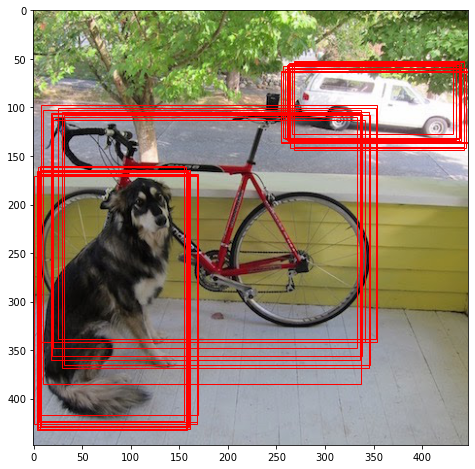

In [9]:
# Plot all bounding boxes.
plot_bounding_boxes(image_path, bboxes, clr='r', linewidth=1)

**At this point, we write a wrapper function to call `nms_rescoring()` and plot the filtered bounding boxes.**

In [10]:
def check_nms(img_path, bboxes, iou_thresh, score_thersh, clr = None):

    # Linear.
    print("Linear rescoring results:")
    bboxes_l_soft = nms_rescoring(dbox_data=bboxes, rescoring=0, 
                                  iou_threshold=iou_thresh, score_threshold=score_thersh)
    print("No. of boxes",len(bboxes_l_soft))
    plot_bounding_boxes(img_path, bboxes_l_soft, clr = clr, linewidth=3)

    # Gaussian.
    print("Gaussian rescoring results:")
    bboxes_g_soft = nms_rescoring(dbox_data=bboxes, rescoring=1, 
                                  iou_threshold=iou_thresh, score_threshold=score_thersh)
    print("No. of boxes",len(bboxes_g_soft))
    plot_bounding_boxes(img_path, bboxes_g_soft, clr = clr, linewidth=3)

    
    # Hard-NMS.
    print("Hard NMS results:")
    bboxes_h_nms = nms_rescoring(dbox_data=bboxes, soft_nms=False, 
                                 iou_threshold=iou_thresh, score_threshold=score_thersh)
    print("No. of boxes",len(bboxes_h_nms))
    plot_bounding_boxes(img_path, bboxes_h_nms, clr = clr, linewidth=3)
    
    return

Linear rescoring results:
No. of boxes 3


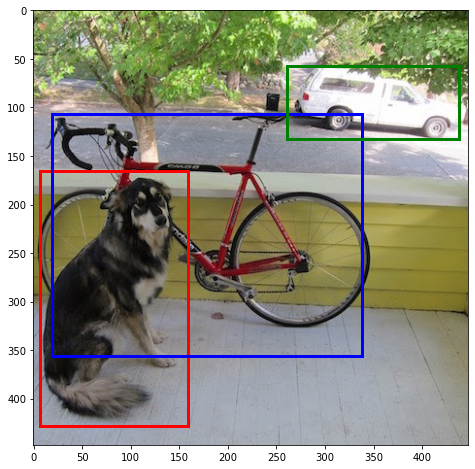

Gaussian rescoring results:
No. of boxes 3


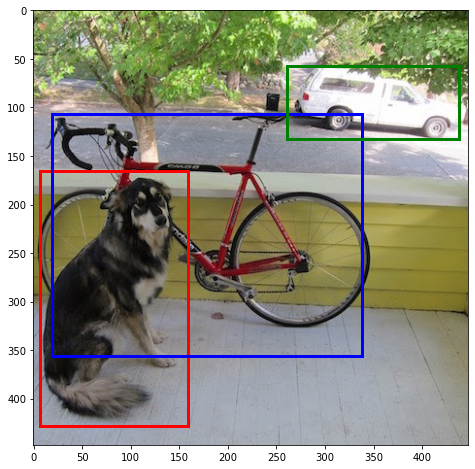

Hard NMS results:
No. of boxes 2


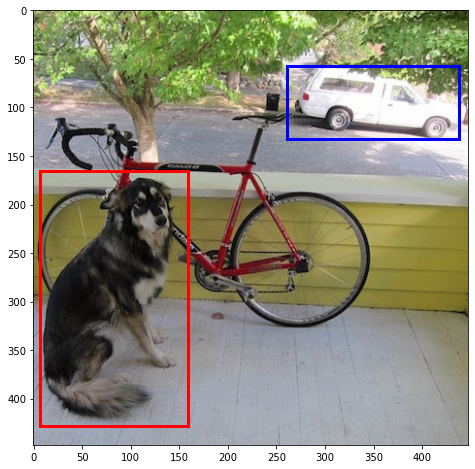

In [11]:
check_nms(img_path=image_path, bboxes=bboxes, iou_thresh=0.24, score_thersh=0.2)

In [12]:
image_path = 'data/image.jpg'

# The bounding box data path.
bbox_path = 'data/bboxes_new.npy'

# Load the bounding box file.
bboxes = np.load(bbox_path).astype(np.float32)


print('Total no of bounding boxes: {}'.format(len(bboxes)))

Total no of bounding boxes: 8


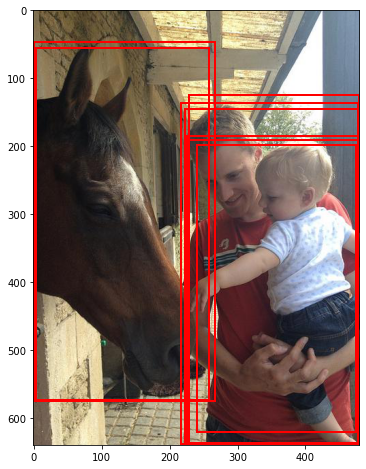

In [13]:
plot_bounding_boxes(image_path, bboxes, clr='r', linewidth=2)

Linear rescoring results:
No. of boxes 3


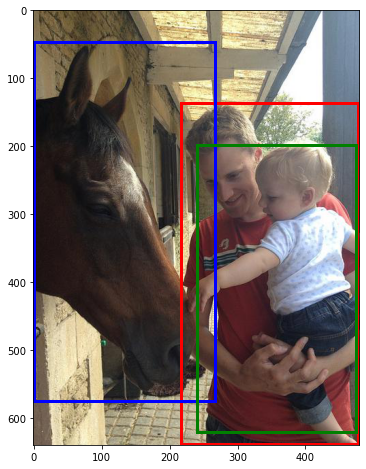

Gaussian rescoring results:
No. of boxes 3


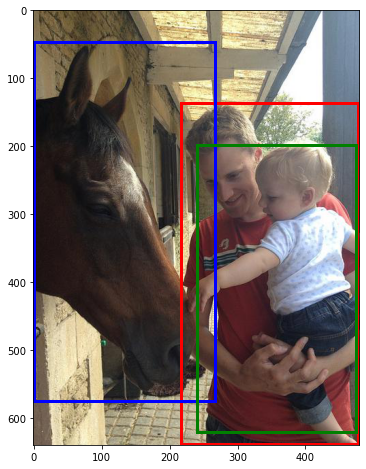

Hard NMS results:
No. of boxes 2


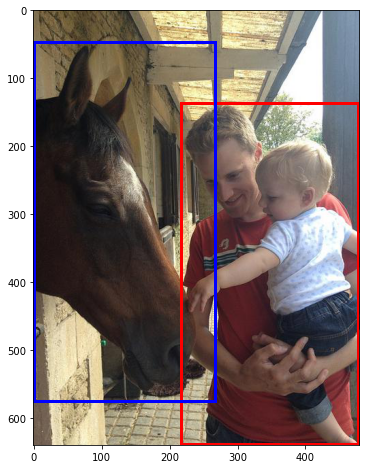

In [14]:
check_nms(image_path, bboxes, iou_thresh=0.5, score_thersh=0.15)

**Here we can see that the NMS algorithm suppresses the bounding box involving the child; while both our Linear and Gaussian Soft-NMS implementation is able to retain the box!**

In [15]:
image_path = 'data/image1.jpg'

# The bounding box data path.
bbox_path = 'data/boxes_1.npy'

# Load the bounding box file.
bboxes = np.load(bbox_path).astype(np.float32)

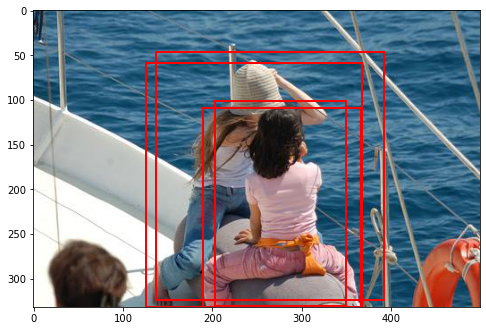

In [16]:
plot_bounding_boxes(image_path, bboxes, clr='r', linewidth=2)

Linear rescoring results:
No. of boxes 2


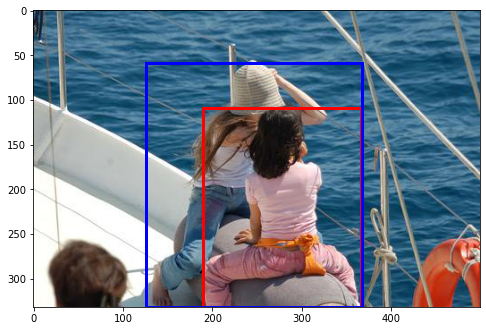

Gaussian rescoring results:
No. of boxes 2


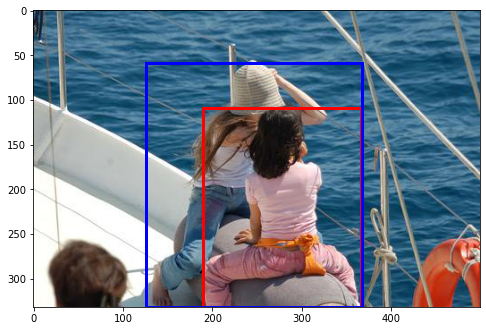

Hard NMS results:
No. of boxes 1


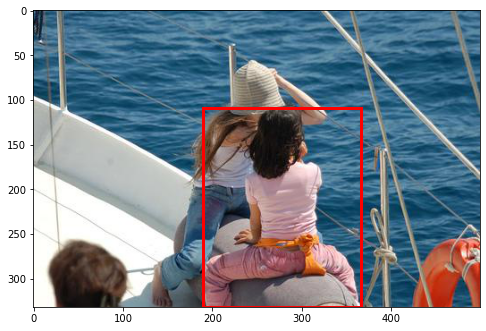

In [17]:
check_nms(image_path, bboxes, iou_thresh=0.5, score_thersh=0.35)

**Similarly, here, too, we see that the NMS algorithm suppresses the bounding box for one of the persons, while both the Linear and Gaussian Soft-NMS implementation is able to retain it!**

In [18]:
image_path = 'data/image2.jpg'

# The bounding box data path.
bbox_path = 'data/boxes_2.npy'

# Load the bounding box file.
bboxes = np.load(bbox_path).astype(np.float32)


print('Total no of bounding boxes: {}'.format(len(bboxes)))

Total no of bounding boxes: 6


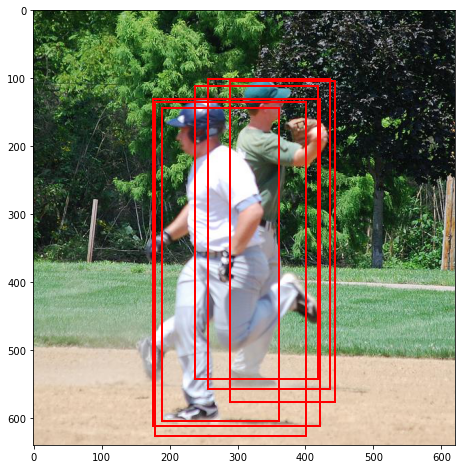

In [19]:
plot_bounding_boxes(image_path, bboxes, clr='r', linewidth=2)

Linear rescoring results:
No. of boxes 2


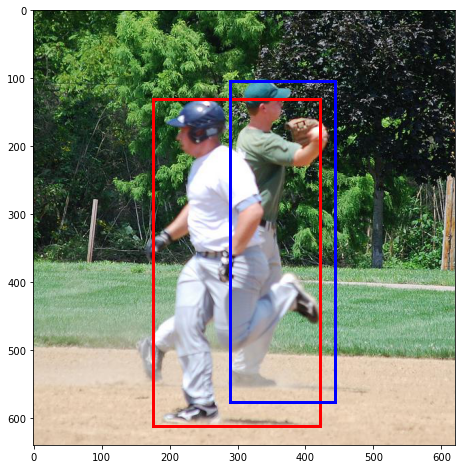

Gaussian rescoring results:
No. of boxes 3


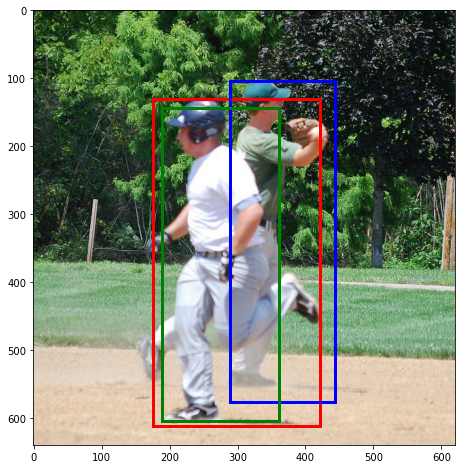

Hard NMS results:
No. of boxes 1


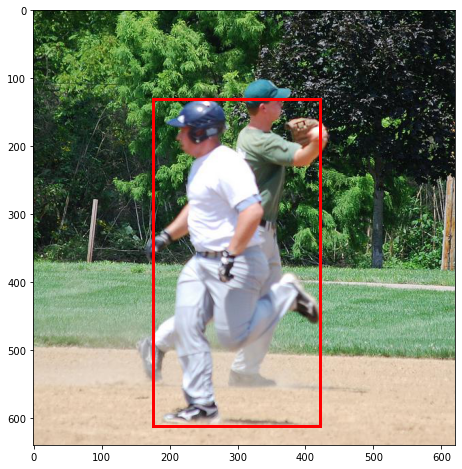

In [20]:
check_nms(image_path, bboxes, iou_thresh=0.4, score_thersh=0.27)

**Similarly, here, too, we see that the NMS algorithm suppresses the bounding box for one of the persons, while both the Linear and Gaussian Soft-NMS implementation is able to retain it!**

**But there is a catch here! Our Gaussian Soft-NMS implementation manages to introduce a False Positive detection (represented by the Green box).**

In [21]:
image_path = 'data/image4.jpg'

# The bounding box data path.
bbox_path = 'data/boxes_4.npy'

# Load the bounding box file.
bboxes = np.load(bbox_path).astype(np.float32)

print('Total no of bounding boxes: {}'.format(len(bboxes)))

Total no of bounding boxes: 21


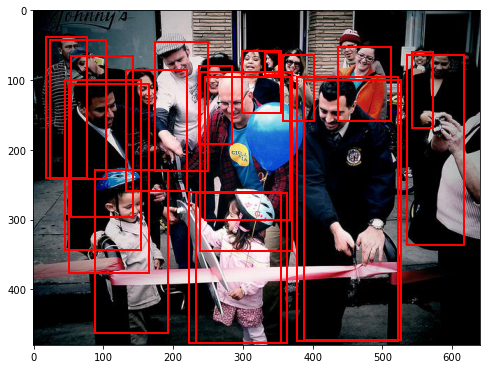

In [22]:
plot_bounding_boxes(image_path, bboxes, clr='r', linewidth=2)

Linear rescoring results:
No. of boxes 18


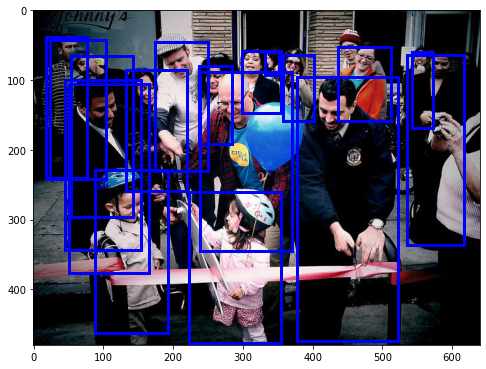

Gaussian rescoring results:
No. of boxes 17


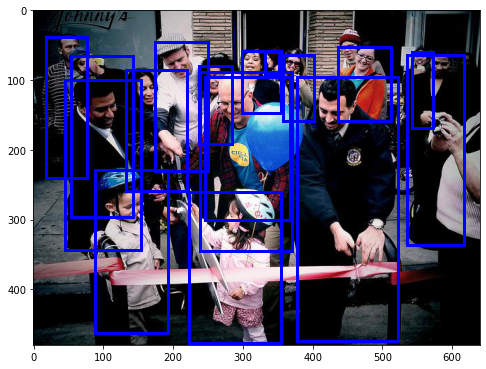

Hard NMS results:
No. of boxes 15


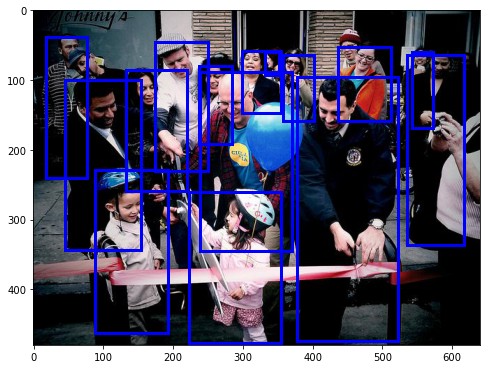

In [23]:
check_nms(image_path, bboxes, iou_thresh=0.5, score_thersh=0.2, clr = 'b')

**In the above image, see how for the person in the extreme top-left corner, the Linear Soft-NMS implementation introduces a False Positive detection.**